In [4]:
# Initialize the SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.types import StringType, DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col, when, count, lit
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [5]:
# Initialize a Spark session

spark = SparkSession.builder.appName("SparkStandaloneTest").getOrCreate()

spark = SparkSession.builder \
    .appName("GCSFilesRead") \
    .config("spark.executor.cores", "80") \
    .config("spark.num.executors", "5") \
    .getOrCreate() 

#     .config("spark.executor.cores", "80") \
#     .config("spark.num.executors", "5") \


# file path 
file_location = "/home/bx2051/dataset1.csv"

def read_csv_with_inferred_schema(file_path):
    """
    Reads a CSV file with inferred schema.
    transfer string data type to factor

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        pyspark.sql.DataFrame: The DataFrame with inferred schema.
    """
    # Read the CSV file with inferred schema
    data = spark.read \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .csv(file_path)
    
    
    return data


df = read_csv_with_inferred_schema(file_location)

24/05/15 21:44:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
# # Column number 
# len(df.columns)  


In [7]:
# # row number 
df.limit(2)

DataFrame[age: int, fy_diastolic_blood_pressure_low: double, fy_systolic_blood_pressure_high: double, fy_hemameba: double, fy_neutrophilic_granulocyte_percentage: double, fy_percentage_of_lymphocytes: double, fy_percentage_of_monocytes: double, fy_absolute_neutrophil_count: double, fy_lymphocyte_number: double, fy_absolute_value_of_monocytes: double, fy_absolute_eosinophil_count: double, fy_absolute_value_of_basophils: double, fy_erythrocyte: double, fy_hemoglobin: double, fy_mean_corpuscular_volume: double, fy_mean_corpuscular_hemoglobin: double, fy_mean_corpuscular_hemoglobin_concentration: double, fy_red_blood_cell_distribution_width_CV: double, fy_red_blood_cell_distribution_width_SD: double, fy_blood_platelet: double, fy_platelet_distribution_width: double, fy_mean_platelet_volume: double, fy_large_platelet_ratio: double, fy_pct: double, fy_whole_blood_viscosity_values_1pas_the_shear_rate_200s: double, fy_whole_blood_viscosity_values_2Pas_shear_rate30s: double, fy_whole_blood_visc

In [123]:
# df.columns

In [124]:
# # Assuming df is your DataFrame
# column_types = df.dtypes

# # Print each column name and its data type if the data type is 'string'
# for name, dtype in column_types:
#     if dtype == "string":  # Added the colon here
#         print(f"Column Name: {name}, Data Type: {dtype}")


In [125]:
## get the selected features's dataset 
def retrieve_selected_features(feature_names, dataset):
    selected_features = [feature for feature in feature_names if feature in dataset.columns]
    selected_dataset = dataset[selected_features]
    return selected_dataset

In [126]:
## testing feature selection 
# selected_df = retrieve_selected_features(mdoel1_features, limited_df)

def testing_selected_features(feature_names, dataset): 
    # Test the retrieve_selected_features function

    # Check if the selected dataset has the expected columns
    assert list(dataset.columns) == feature_names, "Selected dataset columns do not match the expected features"

    # Check if the selected dataset has the same number of rows as the original dataset
    assert len(feature_names) == len(dataset.columns), "Selected dataset has a different number of rows than the original dataset"

    print("PASS")
    
    
# testing_selected_features(mdoel1_features, selected_df)    

In [127]:
def separate_datasets_by_glucose(dataset, glucose_threshold=5.5):
    """
    Separates the dataset into two datasets based on the second year glucose number using PySpark.

    Args:
        dataset (pyspark.sql.DataFrame): The original dataset.
        glucose_threshold (float): The threshold value for separating the datasets
            based on the second year glucose number. Default is 6.1.

    Returns:
        tuple: A tuple containing two datasets:
            - normal_dataset (pyspark.sql.DataFrame): Dataset with glucose_year2 < glucose_threshold.
            - abnormal_dataset (pyspark.sql.DataFrame): Dataset with glucose_year2 >= glucose_threshold.
    """
    normal_dataset = dataset.filter(dataset['sy_glucose'] < glucose_threshold)
    abnormal_dataset = dataset.filter(dataset['sy_glucose'] >= glucose_threshold)
    return normal_dataset, abnormal_dataset\

# Testing the seperate dataset function 
# normal_df, abnormal_df = separate_datasets_by_glucose(limited_df)
# normal_df.count()
# abnormal_df.count()

In [128]:
def combine_train_datasets(dataset1, dataset2):
    """
    Combines two datasets with the same column number and name into a single dataset using PySpark.

    Args:
        dataset1 (pyspark.sql.DataFrame): The first dataset to be combined.
        dataset2 (pyspark.sql.DataFrame): The second dataset to be combined.

    Returns:
        pyspark.sql.DataFrame: The combined dataset.
    """
    combined_dataset = dataset1.union(dataset2)
    return combined_dataset

In [129]:
from pyspark.sql import SparkSession

def test_combine_datasets():
    """
    Test case for the combine_datasets function using PySpark.
    """
    # Create a SparkSession
    spark = SparkSession.builder.appName("CombineDatasetsTest").getOrCreate()

    # Create sample datasets
    data1 = [("John", 25), ("Alice", 30)]
    data2 = [("Bob", 35), ("Emma", 28)]
    schema = ["name", "age"]
    dataset1 = spark.createDataFrame(data1, schema)
    dataset2 = spark.createDataFrame(data2, schema)

    # Call the combine_datasets function
    combined_dataset = combine_train_datasets(dataset1, dataset2)

    # Check if the combined dataset has the expected number of rows
    assert combined_dataset.count() == dataset1.count() + dataset2.count(), \
        "The combined dataset does not have the expected number of rows"

    # Check if the combined dataset contains all rows from both datasets
    assert combined_dataset.subtract(dataset1).count() == dataset2.count(), \
        "The combined dataset does not contain all rows from dataset1"
    assert combined_dataset.subtract(dataset2).count() == dataset1.count(), \
        "The combined dataset does not contain all rows from dataset2"

    print("Function combine_datasets passed the test!")

# Run the test case
test_combine_datasets()

Function combine_datasets passed the test!


In [130]:

## Version1 logistic regression model 
def train_logistic_regression_model(data, max_iter=10, reg_param=0.05, elastic_net_param=1):
    """
    Trains a logistic regression model using the given dataset, feature columns, and label column.

    Args:
        data (pyspark.sql.DataFrame): The input DataFrame containing the features and label.
        max_iter (int): Maximum number of iterations (default: 100).
        reg_param (float): Regularization parameter (default: 0.02).
        elastic_net_param (float): ElasticNet mixing parameter, in range [0, 1] (default: 0.8).

    Returns:
        pyspark.ml.classification.LogisticRegressionModel: The trained logistic regression model.
    """
    train_model_dataset = data.withColumn("diabet",
                                          when(data["glucose"] > 6.1, 1).otherwise(0))

    # Drop the original 'glucose' column if you don't need it anymore
    train_model_dataset = train_model_dataset.drop("glucose")

    assembler = VectorAssembler(inputCols=train_model_dataset.columns[:-1], outputCol="features")
    train_model_dataset = assembler.transform(train_model_dataset)

    tri = LogisticRegression(maxIter=max_iter,
                             regParam=reg_param,
                             elasticNetParam=elastic_net_param,
                             featuresCol="features",
                             labelCol="diabet")

    lr_model = tri.fit(train_model_dataset)

    return lr_model

In [131]:
def predict_logistic_regression_result(model, testData):
    """
    Makes predictions using the trained model on the testing data.

    Args:
        model (pyspark.ml.classification.LogisticRegressionModel): The trained logistic regression model.
        test_data (pyspark.sql.DataFrame): The testing data.

    Returns:
        pyspark.sql.DataFrame: The DataFrame with predicted results and actual labels.
    """
    
    testData = testData.withColumn("diabet", 
                                            when(testData["glucose"] > 6.1, 1).otherwise(0))

    testData = testData.drop("glucose")
    
    # Check if 'features' column exists and drop it
    if 'features' in testData.columns:
        testData = testData.drop('features')

    # Assuming 'actual_outcome' is the column in the original data used as the label
    # Make sure it's included when transforming testData
    testData = testData.withColumn("label", testData["diabet"])
    testData = testData.drop("diabet")
    
    
    assembler = VectorAssembler(inputCols=[col for col in testData.columns if col != "label"], outputCol="features")
    testData = assembler.transform(testData)

        # Make predictions using the trained model
    predictions = model.transform(testData)
    predictions = predictions.select("prediction", "label")
    # Transfer the prediction double type to integer type 
    predictions = predictions.withColumn("prediction", col("prediction").cast("integer"))
    # Example
    # ['prediction',  'label']
       
    return predictions



In [132]:
from pyspark.sql.functions import col, when, count

def calculate_sensitivity_specificity(predictions):
    """
    Calculate sensitivity and specificity from a DataFrame containing labels and predictions.
    
    Args:
    predictions (DataFrame): A DataFrame with two columns: 'label' and 'prediction'.
    
    Returns:
    tuple: Returns a tuple containing sensitivity (True Positive Rate) and specificity (True Negative Rate).
    """
    
    # Calculate confusion matrix components
    metrics = predictions.withColumn("TP", when((col("label") == 1) & (col("prediction") == 1), 1).otherwise(0)) \
                          .withColumn("FN", when((col("label") == 1) & (col("prediction") == 0), 1).otherwise(0)) \
                          .withColumn("FP", when((col("label") == 0) & (col("prediction") == 1), 1).otherwise(0)) \
                          .withColumn("TN", when((col("label") == 0) & (col("prediction") == 0), 1).otherwise(0)) \
                          .agg(
                              count(when(col("TP") == 1, True)).alias("TP"),
                              count(when(col("FN") == 1, True)).alias("FN"),
                              count(when(col("FP") == 1, True)).alias("FP"),
                              count(when(col("TN") == 1, True)).alias("TN")
                          ).collect()[0]
    
    TP, FN, FP, TN = metrics["TP"], metrics["FN"], metrics["FP"], metrics["TN"]

    # Calculate sensitivity (True Positive Rate)
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    # Calculate specificity (True Negative Rate)
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0

#     print("Confusion Matrix")
#     print("\t\tPredicted Positive\tPredicted Negative\tSensitivity")
#     print("Actual Positive\t", TP, "\t\t\t\t", FN, "\t\t", f"{TPR:.3f}")
#     print("Actual Negative\t", FP, "\t\t\t\t", TN, "\t\t", f"{TNR:.3f}")    

    return TPR, TNR

# Example Usage:
# Assuming 'predictions' is a DataFrame with the necessary columns
# TPR, TNR = calculate_sensitivity_specificity(predictions)

In [133]:
def combine_testing_datasets(dataset1, dataset2):
    """
    Combines testing datasets from two datasets and records each data's corresponding dataset.

    Args:
        dataset1 (pyspark.sql.DataFrame): The first dataset.
        dataset2 (pyspark.sql.DataFrame): The second dataset.

    Returns:
        pyspark.sql.DataFrame: A DataFrame with two columns:
            - 'features': The combined testing dataset.
            - 'dataset': The corresponding dataset for each data point ('dataset1' or 'dataset2').
    """
    # Add a column to identify the dataset for each data point
    dataset1 = dataset1.withColumn("dataset", lit("dataset1"))
    dataset2 = dataset2.withColumn("dataset", lit("dataset2"))

    # Combine the two datasets vertically
    combined_dataset = dataset1.union(dataset2)

    dataset_number = combined_dataset.select("dataset").rdd.flatMap(lambda x: x).collect()
    combined_dataset = combined_dataset.drop("dataset")

    return combined_dataset, dataset_number

In [134]:
from pyspark.sql.functions import col, when
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql.functions import row_number

def combine_predictions(prediction1, prediction2, dataset_number):
    """
    Combines predictions from two models based on the dataset designation for each data point.
    
    Args:
        prediction1 (DataFrame): Predictions from the first model, with 'prediction' and 'label'.
        prediction2 (DataFrame): Predictions from the second model, with 'prediction'.
        dataset_number (list): List indicating the dataset for each data point ('dataset1' or 'dataset2').
    
    Returns:
        DataFrame: A DataFrame with combined predictions based on dataset_number designation.
    """
    # Create a window specification without partitioning
    windowSpec = Window.orderBy(lit('A'))  # 'A' is a dummy value to ensure a full scan in order

    # Add a row index to each DataFrame that aligns across both DataFrames
    prediction1 = prediction1.withColumn("id", row_number().over(windowSpec) - 1)
    prediction2 = prediction2.withColumn("id", row_number().over(windowSpec) - 1)

    # Ensure the columns are appropriately named to avoid conflicts and confusion
    prediction1 = prediction1.withColumnRenamed("prediction", "prediction1").drop("label")
    prediction2 = prediction2.withColumnRenamed("prediction", "prediction2")

    # Convert dataset_number list to DataFrame
    ids = spark.createDataFrame([(i, d) for i, d in enumerate(dataset_number)], schema="id int, dataset string")

    # Join predictions with the dataset_number DataFrame using the index
    combined_predictions = prediction1.join(prediction2, "id", "inner").join(ids, "id", "inner")

    # Select predictions based on the dataset
    combined_predictions = combined_predictions.withColumn(
        "combined_prediction",
        when(col("dataset") == "dataset1", col("prediction1"))
        .otherwise(col("prediction2"))
    )

    # Select the required columns and rename them
    combined_predictions = combined_predictions.select(
        col("combined_prediction").alias("prediction"),
        "label"  # Choose label1 or label as needed, assuming label alignment or resolve as needed
    )

    return combined_predictions

In [135]:
def results_matrix(predictions):
    """
    Getting predcition result in confusion matrix and print the matrix.
    
    Args:
    predictions (DataFrame): A DataFrame with two columns: 'label' and 'prediction'.
    
    Returns:
    tuple: Returns a tuple containing sensitivity (True Positive Rate) and specificity (True Negative Rate).
    """
    
    # Calculate confusion matrix components
    metrics = predictions.withColumn("TP", when((col("label") == 1) & (col("prediction") == 1), 1).otherwise(0)) \
                          .withColumn("FN", when((col("label") == 1) & (col("prediction") == 0), 1).otherwise(0)) \
                          .withColumn("FP", when((col("label") == 0) & (col("prediction") == 1), 1).otherwise(0)) \
                          .withColumn("TN", when((col("label") == 0) & (col("prediction") == 0), 1).otherwise(0)) \
                          .agg(
                              count(when(col("TP") == 1, True)).alias("TP"),
                              count(when(col("FN") == 1, True)).alias("FN"),
                              count(when(col("FP") == 1, True)).alias("FP"),
                              count(when(col("TN") == 1, True)).alias("TN")
                          ).collect()[0]
    
    TP, FN, FP, TN = metrics["TP"], metrics["FN"], metrics["FP"], metrics["TN"]

    # Calculate sensitivity (True Positive Rate)
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    # Calculate specificity (True Negative Rate)
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0

    print("Confusion Matrix")
    print("\t\tPredicted Positive\tPredicted Negative\tSensitivity")
    print("Actual Positive\t", TP, "\t\t\t\t", FN, "\t\t", f"{TPR:.3f}")
    print("Actual Negative\t", FP, "\t\t\t\t", TN, "\t\t", f"{TNR:.3f}")    

    return metrics

In [136]:
from pyspark.sql.functions import when, col
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def tenfold_logistics_model(data):
    """
    Performs tenfold cross-validation on the dataset and trains logistic regression models.

    Args:
        data (pyspark.sql.DataFrame): The original dataset.

    Returns:
        tuple: A tuple containing two lists:
            - model1_results: A list of tuples (iteration, sensitivity, specificity) for model 1.
            - model2_results: A list of tuples (iteration, sensitivity, specificity) for model 2.
    """
    # Separate the dataset into abnormal and normal people based on sy_glucose column
    normal_people, abnormal_people =  separate_datasets_by_glucose(data)
    
    # Initialize lists to store the results
    model1_results = []
    model2_results = []

    # Perform tenfold cross-validation
    for i in range(10):
        # Split the abnormal and normal people datasets into train and test data
        abnormal_train, abnormal_test = abnormal_people.randomSplit([0.9, 0.1], seed=i)
        normal_train, normal_test = normal_people.randomSplit([0.9, 0.1], seed=i)

        # Combine the train datasets using combine_train_datasets function
        original_train_data = combine_train_datasets(abnormal_train, normal_train)

        # Combine the test datasets using combine_testing_datasets function
        main_test_data, dataset_number = combine_testing_datasets(normal_test, abnormal_test)

        # Train the original data (model 1)
        model1 = train_logistic_regression_model(original_train_data)

        # Train model 2.1 and model 2.2
        model2_1 = train_logistic_regression_model(normal_train)
        model2_2 = train_logistic_regression_model(abnormal_train)

        # Predict the results for model 1 for total people
        prediction1 = predict_logistic_regression_result(model1, main_test_data)

        # Calculate sensitivity and specificity for model 1
        sensitivity1, specificity1 = calculate_sensitivity_specificity(prediction1)

        # Save the results for model 1
        model1_results.append((i+1, sensitivity1, specificity1))

        # Predict the results for model 2.1 normal people and model 2.2 abnormal people
        prediction2_1 = predict_logistic_regression_result(model2_1, main_test_data)
        prediction2_2 = predict_logistic_regression_result(model2_2, main_test_data)

        # Combine the predictions using combine_predictions function
        prediction2 = combine_predictions(prediction2_1, prediction2_2, dataset_number)

        # Calculate sensitivity and specificity for model 2
        sensitivity2, specificity2 = calculate_sensitivity_specificity(prediction2)

        # Save the results for model 2
        model2_results.append((i+1, sensitivity2, specificity2))

    return model1_results, model2_results

In [161]:
import matplotlib.pyplot as plt

def plot_sensitivity_specificity(model1):
    """
    Plots the sensitivity and specificity graphs for the tenfold cross-validation results.

    Args:
        model1 (list): A list of tuples (iteration, sensitivity, specificity) for model 1.
        model2 (list): A list of tuples (iteration, sensitivity, specificity) for model 2.
    """
    # Extract sensitivity and specificity values for model 1
    iterations1 = [x[0] for x in model1]
    sensitivities1 = [x[1] for x in model1]
    specificities1 = [x[2] for x in model1]


    # Create a new figure and axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot sensitivity and specificity for model 1
    ax1.plot(iterations1, sensitivities1, marker='o', label='Sensitivity')
    ax1.plot(iterations1, specificities1, marker='o', label='Specificity')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Value')
    ax1.set_title('Model 1')
    ax1.set_xticks(iterations1)
    ax1.legend()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

In [138]:
## Build the model using seperate people method 
from pyspark.sql.functions import when, col
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def logistics_seperate_people_model (data):
    """
    Separates the dataset into normal and abnormal people based on sy_glucose column,
    trains logistic regression models, and returns the sensitivity and specificity.

    Args:
        data (pyspark.sql.DataFrame): The original dataset.

    Returns:
        tuple: A tuple containing two tuples:
            - model1_results: A tuple (sensitivity, specificity) for model 1.
            - model2_results: A tuple (sensitivity, specificity) for model 2.
    """
    # Separate the dataset into abnormal and normal people based on sy_glucose column
    normal_people, abnormal_people = separate_datasets_by_glucose(data)

    # Split the abnormal and normal people datasets into train and test data
    abnormal_train, abnormal_test = abnormal_people.randomSplit([0.667, 0.334], seed=30)
    normal_train, normal_test = normal_people.randomSplit([0.667, 0.334], seed=30)

    # Combine the train datasets using combine_train_datasets function
    original_train_data = combine_train_datasets(normal_train, abnormal_train)

    # Combine the test datasets using combine_testing_datasets function
    main_test_data, dataset_number = combine_testing_datasets(normal_test, abnormal_test)

    # Train the original data (model 1)
    model1 = train_logistic_regression_model(original_train_data)

    # Train model 2.1 and model 2.2
    model2_1 = train_logistic_regression_model(normal_train)
    model2_2 = train_logistic_regression_model(abnormal_train)
    
    # Predict the results for model 1 for total people
    prediction1 = predict_logistic_regression_result(model1, main_test_data)
    
    # Get the confusion matrix for model 1
    matrix1 = results_matrix(prediction1)
    
    # Calculate sensitivity and specificity for model 1
    sensitivity1, specificity1 = calculate_sensitivity_specificity(prediction1)

    
    # Predict the results for model 2.1 normal people and model 2.2 abnormal people
    prediction2_1 = predict_logistic_regression_result(model2_1, main_test_data)
    prediction2_2 = predict_logistic_regression_result(model2_2, main_test_data)

    # Combine the predictions using combine_predictions function
    prediction2 = combine_predictions(prediction2_1, prediction2_2, dataset_number)
    
    # Get the confusion matrix for model 2
    matrix2 = results_matrix(prediction2)
    
    # Calculate sensitivity and specificity for model 2
    sensitivity2, specificity2 = calculate_sensitivity_specificity(prediction2)

    return matrix1, (sensitivity1, specificity1), matrix2, (sensitivity2, specificity2)

In [139]:
def average_metrics(results):
    """
    Calculate the average sensitivity and specificity from a list of results.

    Args:
        results (list): List of tuples (iteration, sensitivity, specificity).

    Returns:
        tuple: A tuple containing the average sensitivity and average specificity.
    """
    total_sensitivity = sum(result[1] for result in results) / len(results)
    total_specificity = sum(result[2] for result in results) / len(results)
    return total_sensitivity, total_specificity



In [142]:
##Trainning logistic model with validation 

from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression


def train_logistics_validation_split(data):
    
    
    #trainfer the glucose to binary 1 or 0 based on 6.1 and rename to 
    #dia bet 
    train_model_dataset = data.withColumn("diabet",
                                          when(data["glucose"] > 6.1, 1).otherwise(0))

    # Drop the original 'glucose' column if you don't need it anymore
    train_model_dataset = train_model_dataset.drop("glucose")

    assembler = VectorAssembler(inputCols=train_model_dataset.columns[:-1], outputCol="features")
    train_model_dataset = assembler.transform(train_model_dataset)

    # Create an instance of the LogisticRegression estimator
    undefined_model = LogisticRegression(featuresCol="features", labelCol="diabet")

    # Define the parameter grid
    param_grid = ParamGridBuilder() \
        .addGrid(undefined_model.maxIter, [10, 50, 100]) \
        .addGrid(undefined_model.regParam, [0, 0.005, 0.008, 0.01, 0.02]) \
        .addGrid(undefined_model.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1]) \
        .build()

    # Create a binary classification evaluator
    evaluator = BinaryClassificationEvaluator(labelCol="diabet", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

    # Create a TrainValidationSplit
    tvs = TrainValidationSplit(estimator=undefined_model, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.667)

    # Fit the TrainValidationSplit to the training data
    tvs_model = tvs.fit(train_model_dataset)

    # Get the best model
    best_model = tvs_model.bestModel

    return best_model

In [178]:
def tenfold_logistics_tuning_model(data):
    """
    Performs tenfold cross-validation on the dataset and trains logistic regression models.

    Args:
        data (pyspark.sql.DataFrame): The original dataset.

    Returns:
        tuple: A tuple containing two lists:
            - model1_results: A list of tuples (iteration, sensitivity, specificity) for model 1.
            - model2_results: A list of tuples (iteration, sensitivity, specificity) for model 2.
    """
    # Separate the dataset into abnormal and normal people based on sy_glucose column
    normal_people, abnormal_people =  separate_datasets_by_glucose(data)
    
    # Get the features of different model 
    feature1, feature2_1, feature2_2 = retrive_features()
    # Initialize lists to store the results
    model1_results = []
    model2_results = []

    # Perform tenfold cross-validation
    for i in range(10):
        # Split the abnormal and normal people datasets into train and test data
        abnormal_train, abnormal_test = abnormal_people.randomSplit([0.9, 0.1], seed=i)
        normal_train, normal_test = normal_people.randomSplit([0.9, 0.1], seed=i)

        # Combine the train datasets using combine_train_datasets function
        original_train_data = combine_train_datasets(abnormal_train, normal_train)
        
        # Combine the test datasets using combine_testing_datasets function
        main_test_data, dataset_number = combine_testing_datasets(normal_test, abnormal_test)

        original_train_data = retrieve_selected_features(feature1, original_train_data)
        # Train the original data (model 1)
        model1 = train_logistics_validation_split(original_train_data)

        # Train model 2.1 and model 2.2
        normal_train = retrieve_selected_features(feature2_1, normal_train)
        model2_1 = train_logistics_validation_split(normal_train)
        
        abnormal_train = retrieve_selected_features(feature2_2, abnormal_train)
        model2_2 = train_logistics_validation_split(abnormal_train)

        # Predict the results for model 1 for total people
        test_data_model1 = retrieve_selected_features(feature1, main_test_data)
        prediction1 = predict_logistic_regression_result(model1, test_data_model1)

        # Calculate sensitivity and specificity for model 1
        sensitivity1, specificity1 = calculate_sensitivity_specificity(prediction1)

        # Save the results for model 1
        model1_results.append((i+1, sensitivity1, specificity1))

        # Predict the results for model 2.1 normal people and model 2.2 abnormal people
        test_data_model2_1 = retrieve_selected_features(feature2_1, main_test_data)
        prediction2_1 = predict_logistic_regression_result(model2_1, test_data_model2_1)
        
        test_data_model2_2 = retrieve_selected_features(feature2_2, main_test_data)
        prediction2_2 = predict_logistic_regression_result(model2_2, test_data_model2_2)

        # Combine the predictions using combine_predictions function
        prediction2 = combine_predictions(prediction2_1, prediction2_2, dataset_number)

        # Calculate sensitivity and specificity for model 2
        sensitivity2, specificity2 = calculate_sensitivity_specificity(prediction2)

        # Save the results for model 2
        model2_results.append((i+1, sensitivity2, specificity2))

    return model1_results, model2_results

In [179]:
def retrive_features():
    ## Extract the Featreus on each model 
    model1_features = read_csv_with_inferred_schema("/home/bx2051/originial_features.csv")

    model2_1_features = read_csv_with_inferred_schema("/home/bx2051/best_features_normal.csv")

    model2_2_features = read_csv_with_inferred_schema("/home/bx2051/best_features_ab.csv")

    # Transfer the features to list 
    features_1 = model1_features.select("Best Features").rdd.flatMap(lambda x: x).collect()
    features_1.append("glucose")
    feature_2_1 = model2_1_features.select("Best Features").rdd.flatMap(lambda x: x).collect()
    feature_2_1.append("glucose")
    feature_2_2 = model2_2_features.select("Best Features").rdd.flatMap(lambda x: x).collect()
    feature_2_2.append("glucose")

#     .append("glucose")
    return features_1, feature_2_1, feature_2_2



In [180]:
model1, model2 = tenfold_logistics_tuning_model(df)

24/05/15 12:26:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:26:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:29:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:29:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:32:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 12:32:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/15 1

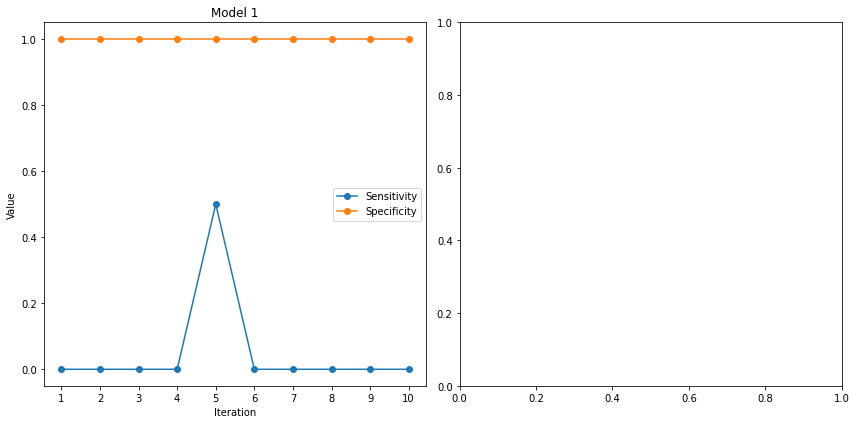

In [181]:
plot_sensitivity_specificity(model1)

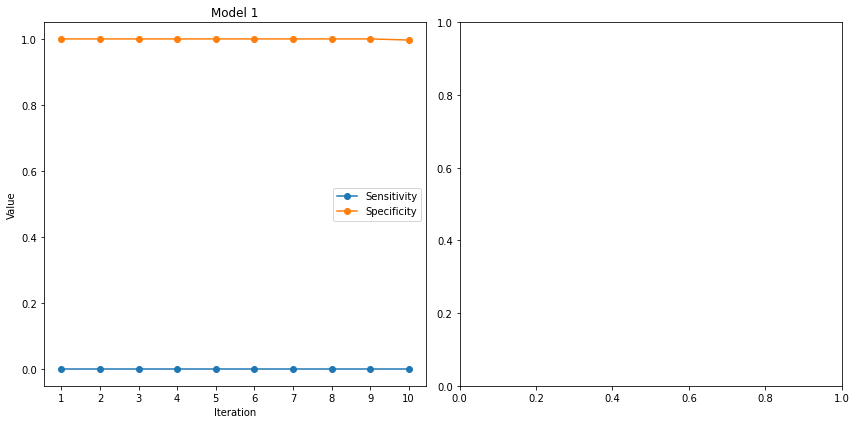

In [182]:
plot_sensitivity_specificity(model2)